Импортируем необходимые модули:

In [4]:
import zlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

Загружаем тестовые предложения, записанные построчно в текстовый файл. Архивируем каждое предложение при помощи zlib и считаем коэффициент сжатия:

In [6]:
with open('/content/test.txt', 'r', encoding='utf-8') as f:
  text = f.read()
sntc = text.split('\n')

l_sntc = []  # длины предложений
k_zlib = []  # коэффициенты сжатия для каждого предложения

for s in sntc:
  l_sntc.append(len(s))
  k_zlib.append(len(s) / len(zlib.compress(s.encode(), -1)))

Посмотрим на распределение длин предложений:

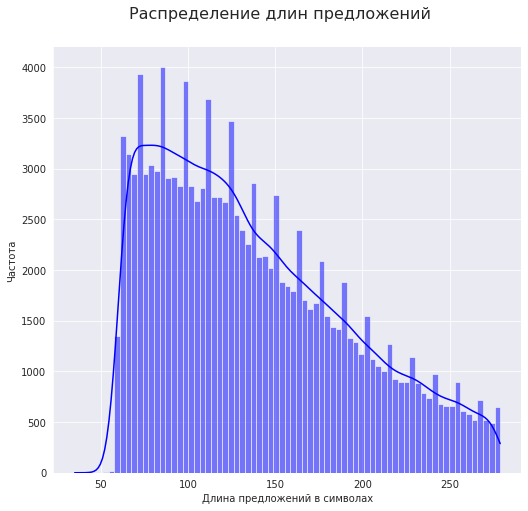

In [7]:
sns.set_style("darkgrid")
h = sns.displot(l_sntc, kde = True, color = 'b', height = 7)
h.fig.subplots_adjust(top = 0.9, left = 0.05)
h.fig.suptitle('Распределение длин предложений', fontsize = 16)
h.set(xlabel = 'Длина предложений в символах', ylabel = 'Частота')

Длины предложений варьируются в диапазоне от 50 до 280 символов.

### Посмотрим, как длина качественных предложений влияет на коэффициент сжатия.

Для этого:

1.   Возьмем диапазон длин предложений с наибольшей частотой (25 - 75 перцентиль).

- в нашем случае это длины от 92 до 175 символов.

In [8]:
mp_1 = np.percentile(np.array(l_sntc), [25, 75])
print('Диапазон: ' + str(mp_1))

Диапазон: [ 92. 175.]


2.   Разобьем эти предложения на примерно одинаковые по длине группы. Максимальное отклонение длин предложений в одной группе будет равняться отклонению между 25 и (25 + w) перцентилем **или** 75 и (75 - w) перцентилем (выбираем **меньшее** из двух дельт), где w - окно (принимаем 2.5 перцентиля).

- считаем максимальное отклонение длин предложений в одной группе:

In [9]:
w = 2.5  # окно для перцентилей
mp_2 = np.percentile(np.array(l_sntc), [25 + w, 75 - w])
dl = int(min(mp_2[0] - mp_1[0], mp_1[1] - mp_2[1]))
print('Максимальное отклонение длин предложений в одной группе: ' + str(dl))

Максимальное отклонение длин предложений в одной группе: 3


- разбиваем предложения на группы:

In [10]:
# сортируем список с длинами предложений
id_sntc = range(len(sntc))  # порядковые номера предложений
x = zip(l_sntc, id_sntc)
xs = sorted(x, key = lambda tup: tup[0])
l_sntc_s = [x[0] for x in xs]
id_sntс_s = [x[1] for x in xs]

gr = 0  # количество групп
k_gr = [[]]  # коэффициенты сжатия всех предложений в группе
l_gr = [[]]  # длины всех предложений в группе
sl0 = l_sntc_s[l_sntc_s.index(mp_1[0])] # начальное значение длины в группе

nt = l_sntc_s.index(mp_1[1])
for i in range(nt, len(l_sntc_s)):
    if l_sntc_s[i] > l_sntc_s[nt]:
        nt = i
        break

for i in range(l_sntc_s.index(mp_1[0]), nt):
    if l_sntc_s[i] > sl0 + dl:
        sl0 = l_sntc_s[i]
        k_gr.append([])
        l_gr.append([])
        gr += 1
    else:
        k_gr[gr].append(k_zlib[id_sntс_s[i]])
        l_gr[gr].append(l_sntc_s[i])

print('Количество групп: ' + str(gr))

Количество групп: 20


- итак, мы получили 20 групп. 

3.   Предполагаем, что пятидесятому перцентилю каждой группы соответствует качественное предложение и посмотрим на график зависимости коэффициента сжатия этих предложений от их длины:

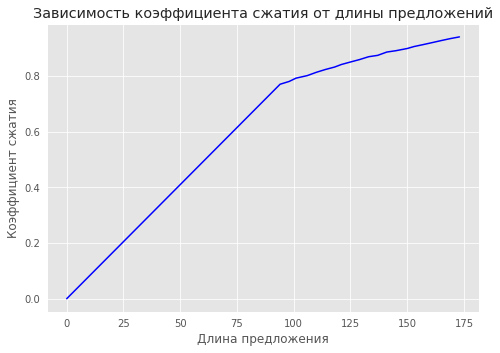

In [11]:
x = [0]
y = [0]

for i in range(gr + 1):
    x.append(np.percentile(np.array(l_gr[i]), 50))
    y.append(np.percentile(np.array(k_gr[i]), 50))

matplotlib.style.use('ggplot')
graph = plt.figure()
axes = graph.add_axes([0, 0, 1, 1])
axes.set_xlabel('Длина предложения')
axes.set_ylabel('Коэффициент сжатия')
axes.set_title('Зависимость коэффициента сжатия от длины предложений')
axes.plot(x, y, color='b')

- наблюдаем степенную функцию вида y = a * x ** b.

### Аппроксимируем функцию с помощью МНК:



In [12]:
x = np.array(x)
y = np.array(y)

#  МНК
def func(x, a, b):
    return a * x ** b

popt, pcov = curve_fit(func, x, y, (0.27, 0.24), maxfev=10 ** 6)
a, b = popt

print('a = {0}\nb = {1}'.format(*tuple(popt)))
print('Коэффициент корреляции: ' + str(np.corrcoef(y, a * x ** b)[0][1]))

a = 0.17601951773514363
b = 0.3256903074228561
Коэффициент корреляции: 0.9999489378452683


Изобразим графически разницу между полученной степенной функцией зависимости коэффициента сжатия от длин предложений (на всём диапазоне длин 50 - 280 символов) и коэффициентом сжатия, если бы он не зависел от длин. Для этого вводим постоянную переменную "c" (функция y = c), которую принимал бы нормальный коэффициент сжатия, если бы он не зависел от длины (на пятидесятом перцентиле всех коэффициентов сжатия):

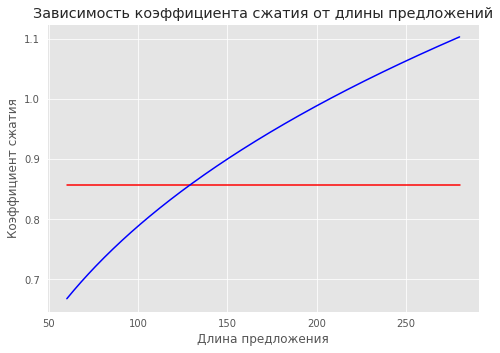

In [13]:
c = np.percentile(np.array(k_zlib), 50)

graph = plt.figure()
axes = graph.add_axes([0, 0, 1, 1])
axes.set_xlabel('Длина предложения')
axes.set_ylabel('Коэффициент сжатия')
axes.set_title('Зависимость коэффициента сжатия от длины предложений')
axes.plot([60, 280], [c, c], color='r')
axes.plot(range(60, 281), a * np.array(range(60, 281)) ** b, color='b')

Разница более чем существенная. Коэффициент сжатия для предложений короче ~130 символов будет заниженным, а для предложений длиннее ~130 символов - наоборот завышенным. И это можно заметить на практике. Если отсеивать предложения разной длины по коэффициенту сжатия без корректировки, то отсеются преимущественно более длинные предложения. Таким образом, **предложения разных длин некорректно отсеивать по одному распределению коэффициента сжатия.** И чем больше разброс длин предложений в корпусе, тем более некорректный результат мы получим.

### Делаем поправку коэффициента сжатия всех предложений в зависимости от их длины:

In [20]:
k_zlib_f = np.array(k_zlib) * c / (a * np.array(l_sntc) ** b)

И напоследок посмотрим на примере, какие предложения отсеиваются после корректировки и **не отсеялись бы без неё:**

- в нашем случае предложения уже очищены от технического мусора, поэтому в качестве примера отсеиваем только заспамленные предложения

In [21]:
p_zlib_1 = np.percentile(np.array(k_zlib), 99.95)
p_zlib_2 = np.percentile(np.array(k_zlib_f), 99.95)

for i in range(len(sntc)):
  if k_zlib_f[i] > p_zlib_2 and k_zlib[i] <= p_zlib_1:
    print(sntc[i])

WACC доля собственного капитала стоимость собственного капитала доля за много капитала стоимость за много капитала ставка налога
Варианты проектов среднеквадратическое отклонение, у среднеквадратическое отклонение, среднеквадратическое отклонение
Кризисное состояние СОС СОС СОС СОС СОС СДИ СДИ СДИ СДИ СДИ
Неравенство соблюдено, неравенство не соблюдено, неравенство не соблюдено
Стиральный порошок Алеся, стиральный порошок Айсберг, стиральный порошок Оптим, стиральный порошок Дося, стиральный порошок Ласка
Пересчитанный план сумма уровень сумма уровень сумма уровень сумма уровень
Печенье Весенняя рапсодия с арахисом, Весенняя рапсодия с кунжутом, Летняя рапсодия с арахисом, Летняя рапсодия с кунжутом
Реальный уровень конкурентоспособности производства продукции потенциальный уровень конкурентоспособности производства продукции
Категория общим объемом более категория общим объемом категория общим объемом
Показатели ОЗ ГОСНИТИ ОЗ ГОСНИТИ ОЗ ГОСНИТИ ОЗ ГОСНИТИ ОЗ И ГОСНИТИ
Ударная вязкость

Как видим, это **короткие** предложения, для которых был **занижен** коэффициент сжатия. На практике довольно редко в корпусе встречаются предложения одинаковой длины, как правило разброс длин довольно существенный.